In [3]:
import sys
sys.path.append('/auto/home/filya/3DMolGen')
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import ast
from loguru import logger as log
from tqdm import tqdm  


import datamol as dm
from rdkit import Chem
from rdkit.Chem import AllChem

from molgen3D.data_processing.preprocessing_forked_ET_Flow import load_pkl, load_json, embed_coordinates
from molgen3D.evaluation.inference import parse_molecule_with_coordinates
from get_cartesian_from_spherical import parse_molecule_with_spherical_coordinates
from get_spherical_from_cartesian import embed_coordinates_spherical

import importlib
import get_cartesian_from_spherical as to_reload1
import get_spherical_from_cartesian as to_reload2
importlib.reload(to_reload1)
importlib.reload(to_reload2)

# import importlib
# importlib.reload(get_cartesian_from_spherical)

embedding_func_selector = {
    "cartesian": embed_coordinates,
    "spherical": embed_coordinates_spherical
}
decoding_func_selector = {
    "cartesian": parse_molecule_with_coordinates,
    "spherical": parse_molecule_with_spherical_coordinates
}

global_rmsds = []

def stat_log(rmsds):
    max_rmsd = np.max(rmsds)
    mean_rmsd = np.mean(rmsds)
    percentile95 = np.percentile(rmsds, 95)
    log.info(f"Maximum RMSD: {max_rmsd}")
    log.info(f"Mean RMSD: {mean_rmsd}")
    log.info(f"95th Percentile: {percentile95}")
    # plt.figure(figsize=(8, 6))
    # plt.hist(rmsds, bins=50, alpha=0.7, color='blue', edgecolor='black')
    # plt.xlabel("RMSD")
    # plt.ylabel("Frequency")
    # plt.title("Distribution of RMSDs")
    # plt.show()
    # print(np.sort(rmsds)[::-1])

def validate(raw_path, embedding_type, limit, precision, single = False, cur_id = -1): #dest_folder_path, indices_path,
    partitions = ["qm9", "drugs"]
    embedding_function = embedding_func_selector[embedding_type]
    decoding_function = decoding_func_selector[embedding_type]
    if not os.path.exists("molecules"):
        os.makedirs("molecules")
    writer = Chem.SDWriter("molecules/special_mol.sdf")
    writer1 = Chem.SDWriter("molecules/special-rec.sdf")
    writer_error = Chem.SDWriter("molecules/error.sdf")

    for partition in partitions:
        # dest_path = osp.join(dest_folder_path, partition.upper())
        # train_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                                 "train_indices.npy"]), allow_pickle=True)))
        # val_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                             "val_indices.npy"]), allow_pickle=True)))
        # log.info(f"{partition} indices contain train:{len(train_indices)}, valid:{len(val_indices)},"\
        #             f" total:{len(train_indices)+len(val_indices)} samples")
        mols = load_json(osp.join(raw_path, f"summary_{partition}.json"))
        for id, (mol_id, mol_dict) in tqdm(
            enumerate(mols.items()),
            total=len(mols),
            desc=f"Processing molecules of {partition}",
        ):
            # if id < 8400:
            #     continue
            # if id >= limit:
            #     break
            if id % 1000 == 999:
                stat_log(global_rmsds)
            # if single and id != cur_id:
            #     continue   

            try: 
                mol_pickle = load_pkl(os.path.join(raw_path, mol_dict["pickle_path"]))
                confs = mol_pickle["conformers"]    
                for conf in confs:
                    mol, geom_id = conf["rd_mol"], conf["geom_id"]
                    # suppl = Chem.SDMolSupplier("/auto/home/filya/3DMolGen/molgen3D/data_processing/mol_9496-orig.sdf")
                    # mol = suppl[0]
                    mol_copy = Chem.Mol(mol)
                    canonical_smiles = dm.to_smiles(
                        mol,
                        canonical=True,
                        explicit_hs=True,
                        with_atom_indices=False,
                        isomeric=False,
                    )
                    if '.' in canonical_smiles:
                        continue
                    atom_order = list(map(int, ast.literal_eval(mol.GetProp('_smilesAtomOutputOrder'))))
                    embedded_smiles = embedding_function(mol, canonical_smiles, atom_order, precision)
                    
                    # sample = {"canonical_smiles": canonical_smiles,
                    #             "geom_embed_coordinatesid": geom_id, 
                    #             "embedded_smiles": embedded_smiles}
                    mol1 = decoding_function(embedded_smiles)
                    rmsd = AllChem.GetBestRMS(mol, mol1)
                    global_rmsds.append(rmsd)
                    if rmsd > 1:
                        writer.write(mol_copy)
                        writer1.write(mol1)
                        log.info(canonical_smiles)
                        log.info(len(confs))
                        log.info(id)
                        log.info(rmsd)

            except Exception as e:
                log.error(f"Error: {e} for molecule {canonical_smiles}, id {id}")
                writer_error.write(mol)
    
    writer.close()
    writer1.close()
    writer_error.close()
    
    rmsds = np.array(global_rmsds)
    return rmsds

In [4]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
# dest_folder_path = "geom"
# os.makedirs(dest_folder_path, exist_ok=True)
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 10000000

# rmsds = validate(raw_path, embedding_type, limit, precision=4, single=True, cur_id=994) # dest_folder_path, indices_path
rmsds = validate(raw_path, embedding_type, limit, precision=4)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 993/133258 [00:36<26:22, 83.60it/s]  2025-03-11 13:16:48.691 | INFO     | __main__:stat_log:46 - Maximum RMSD: 0.21511762942601015
2025-03-11 13:16:48.692 | INFO     | __main__:stat_log:47 - Mean RMSD: 0.00018414749734158088
2025-03-11 13:16:48.692 | INFO     | __main__:stat_log:48 - 95th Percentile: 0.0004608567814238046
Processing molecules of qm9:   1%|▏         | 1992/133258 [01:09<23:21, 93.65it/s]   2025-03-11 13:17:21.536 | INFO     | __main__:stat_log:46 - Maximum RMSD: 0.21511762942601015
2025-03-11 13:17:21.537 | INFO     | __main__:stat_log:47 - Mean RMSD: 0.0002710730155869956
2025-03-11 13:17:21.537 | INFO     | __main__:stat_log:48 - 95th Percentile: 0.001059339574577664
Processing molecules of qm9:   2%|▏         | 2996/133258 [04:12<2:37:22, 13.80it/s] 2025-03-11 13:20:24.713 | INFO     | __main__:stat_log:46 - Maximum RMSD: 0.37523874830143344
2025-03-11 13:20:24.713 | INFO     | __main__:stat_log:47 - Mean RMSD: 0.00026105

KeyboardInterrupt: 

In [3]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
# dest_folder_path = "geom"
# os.makedirs(dest_folder_path, exist_ok=True)
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 10000000

# rmsds = validate(raw_path, embedding_type, limit, precision=4, single=True, cur_id=994) # dest_folder_path, indices_path
rmsds = validate(raw_path, embedding_type, limit, precision=4)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 990/133258 [00:43<37:05, 59.43it/s]  2025-03-11 12:18:14.530 | INFO     | __main__:stat_log:44 - Maximum RMSD: 0.21511762942601015
2025-03-11 12:18:14.531 | INFO     | __main__:stat_log:45 - Mean RMSD: 0.00018414749734158088
2025-03-11 12:18:14.531 | INFO     | __main__:stat_log:46 - 95th Percentile: 0.0004608567814238046
Processing molecules of qm9:   1%|▏         | 1998/133258 [01:20<27:55, 78.32it/s]   2025-03-11 12:18:51.927 | INFO     | __main__:stat_log:44 - Maximum RMSD: 0.21511762942601015
2025-03-11 12:18:51.927 | INFO     | __main__:stat_log:45 - Mean RMSD: 0.0002710730155869956
2025-03-11 12:18:51.927 | INFO     | __main__:stat_log:46 - 95th Percentile: 0.001059339574577664
Processing molecules of qm9:   2%|▏         | 2995/133258 [03:54<3:21:05, 10.80it/s] 2025-03-11 12:21:26.202 | INFO     | __main__:stat_log:44 - Maximum RMSD: 0.37523874830143344
2025-03-11 12:21:26.202 | INFO     | __main__:stat_log:45 - Mean RMSD: 0.00026105

KeyError: 'pickle_path'

Processing molecules of qm9:   1%|          | 745/133258 [00:02<09:22, 235.69it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 949/133258 [00:03<09:50, 223.94it/s][18:10:09] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:10:09] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1050/133258 [00:03<07:13, 304.79it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2092/133258 [00:08<02:43, 800.39it/s][18:10:14] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:10:14] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:49<21:09, 100.99it/s] 

Maximum RMSD: 0.006011901342061139
Mean RMSD: 0.004702777946379792
95th Percentile: 0.005228246823179082


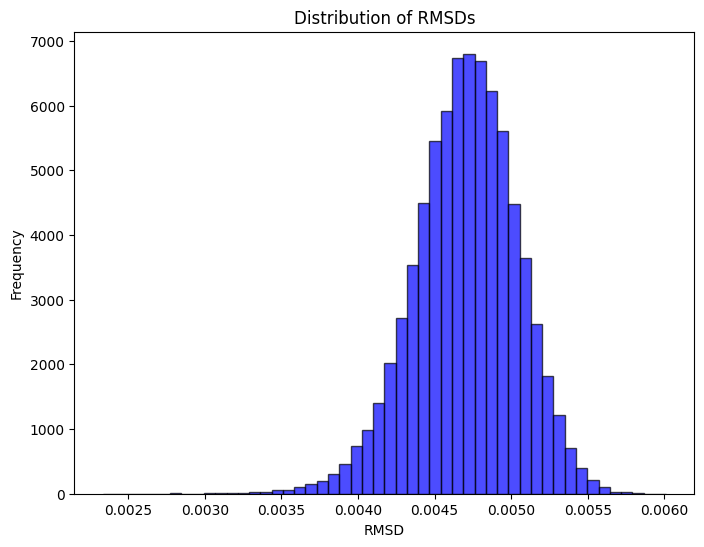

In [9]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=2)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 753/133258 [00:02<09:02, 244.34it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 912/133258 [00:03<11:26, 192.69it/s][18:11:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:11:49] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1029/133258 [00:03<06:24, 343.91it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2082/133258 [00:07<02:28, 884.49it/s][18:11:54] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:11:54] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:37<15:50, 134.89it/s] 

Maximum RMSD: 6.085108419891015e-06
Mean RMSD: 4.716564828831656e-06
95th Percentile: 5.236215178110685e-06


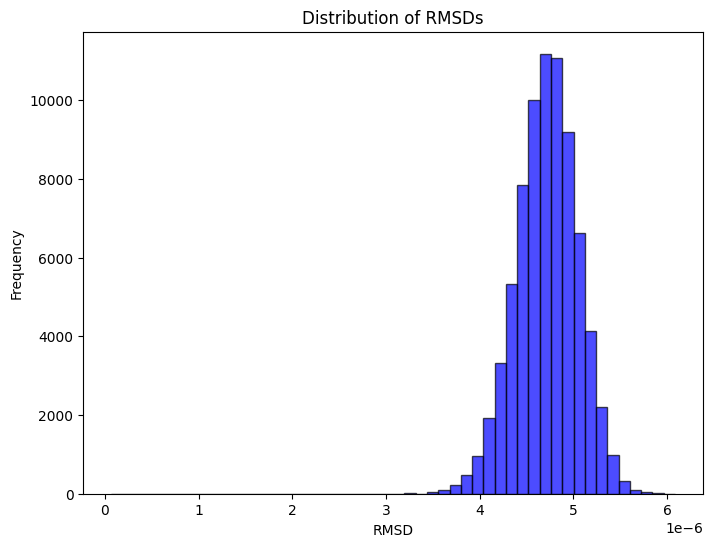

In [10]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=5)
stat_log(rmsds)